In [158]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib notebook

# load up dependencies and functions, Note pyGSSHA_functions.py and  GSSHA.exe MUST be in kernal's working dir
%run pyGSSHA_functions.py

### Specify the rainfall date_range 
Notes: 


- PrjName   =  the project name under which the WMS file is saved
- Input_Precip_df - A dataframe of timerseries precipitation data Note that this has to be in memory INSIDE of the current - script
- Precip_column_Name - The column in the above Input_Precip_df to use
- StartDate - Desired start date of the run (note will work if no hours or minutes but best to add them)
- EndDate  - Desired end date of the run 
- Lat lon of the gauge site, important for GSSHA calculations  (Needs to be formatted as string) 
- RainSeries_timestep_Mins - The timestep of the input rainfall data from Input_Precip_df

Autovariables, can be added if needed 
- PrjDir= os.path.join('.', 'RUN')    = can be specified if its not in a RUN subdirectory of the pwd
- ImpPrecip_units="Inches" - Units of the precip df, this converts it to mm before running in GSSHA as mm is the default GSSHA units
- GageName="mooface" - name of gauge, not so important

### Create/ read in some in-memory dataframes that the functions will use

In [58]:
# There needs to be a cell in here that reads in a rainfall file into memory, 
Input_Precip_File = os.path.join(".", "data/Precip", "KAHAKULOARain.csv")
Input_Precip_df = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 

# while we are at it read in the streamflow data too
Input_Stream_df = pd.read_csv(os.path.join(".", "data", 'WailukuFlow.csv'))#.set_index('datetime')
Input_Stream_df['datetime'] = pd.to_datetime(Input_Stream_df['datetime'], errors='coerce')
Input_Stream_df.set_index('datetime', inplace=True)
StreamFlow_column_Name = 'WailukuFlow'

# and also make a dataframe of the biggest events to use while iterating
biguns = Biguns_large_event_finder(Input_Stream_df, StreamFlow_column_Name, num_top_events = 30, resample_timestep='1D')

### Parameters for gag and other files

In [53]:
PrjName = 'Iao_v2_Soils_inflf_100m'
Input_Precip_df = Input_Precip_df
Precip_column_Name = "RF_mm"
# Event Variables 
StartDate   =  "2004-03-20 00:00"
EndDate     =    "2004-03-24 00:00"
RainSeries_timestep_Mins = 60
Lat  = "753250.0"      # For Waihehe 753354,    # For WaiehuKou,"758000.0"    # for Iao 753250
Lon  = "2310140.0"      # For Waihehe 2314472,   # For WaiehuKou,"2315555.0"   # for Iao 2310140
RUN_dir = os.path.join('.', 'RUN')

### Parameters for .CMT file 

In [54]:
#Step 1)  Need to specify in this list each of the codes used in WMS that are for parameters and dont contain actual values  
Code_list_in_WMS = [
    "-251",
    "-252",
    "-253",
    "-254",
    "-255",
    "-256",
    "-257",
    "-2211",
    "-2212",
    "-2213",
    "-2214",
    "-2215",
    "-2216",
    "-2217",
    "-107",
    "-108",
    "-1014",
    "-1015",
    "-1016",
    "-1017",
    "-1021",
    "-1022", 
    "-351",  
    "-3211"]

# Step 2) Read in frame of base values for all other parameter codes not explicitly modified by the above cell 
Code_Key_df = pd.read_csv(os.path.join('.', 'data', 'Parameter_Codes.csv')) 

# Step 3 define CMT Parameters to Iterate over 
Param_1_code = "-251"                             # For each need to define the code and 
Param_1_name = "HYDR_COND_251"
HYDR_COND_251 = equal_spacing(0.1, 100, 5)   # The range of values to sub-in 

Param_2_code =  "-2211"  
Param_2_name =  "HYDR_COND_2211"
HYDR_COND_2211 = equal_spacing(1, 5, 2); print("param values are {}".format(HYDR_COND_2211))    # log_spacing(-1, 2, 2)

# Note that it is possible to iterate over individual paramaters in isolation, or change multiple ones each iteration 


param values are ['1.0' '5.0']


#### Iterate over one cmt paraater at a time 

 Things that need manual changing are marked as #******

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -0.9878533890508663


<IPython.core.display.Javascript object>


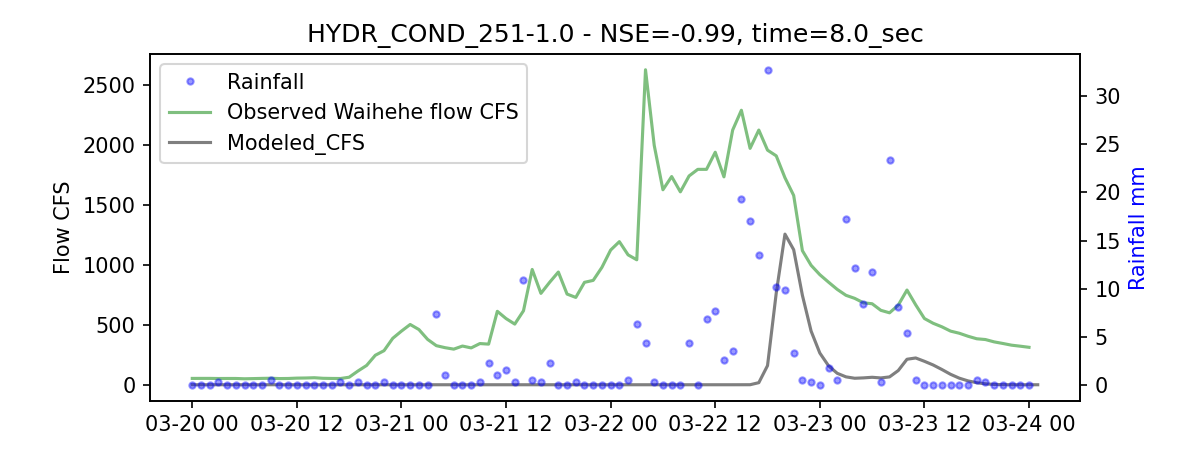

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -1.2966013341191007


<IPython.core.display.Javascript object>


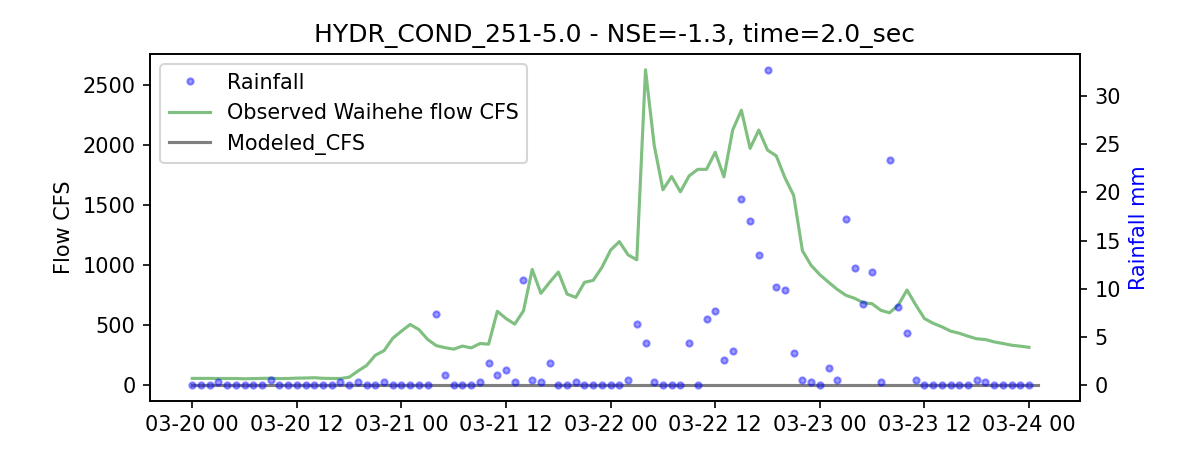

In [6]:
# Ready to Iterate over one cmt parameter 

run_list = HYDR_COND_2211      #******

for value in run_list:
    # This is critical for each run that have a cmt file with 000000 parameters, as it removed them
    refresh_model(PrjName)    # Nuke out the RUN directory to start fresh
    
    # for accounting which run is happening 
    param_code = Param_2_code   #******
    param_name = Param_2_name   #******
    param_val  = value
    
    # Set the parameters in the cmt file
    cmt_prama_jama(param_code, param_val, PrjName)   # Set the parameter(s) for the run
    assign_cmt_base_vals(Code_Key_df, Code_list_in_WMS, PrjName)  # Use the dataframe and list of parameters above to assign the base values to all 
    
    
    # Rewrite Gag file and make run length the same as the file 
    Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                       Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                       Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")
    
    # use unique start date to create streamflow obs file 
    SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)
    
##### RUN GSSHA    ######
    elapsed = run_GSSHA(PrjName, RUN_dir)

    # Postprocessing and plotting 
    OutHydro = process_otl_file(StartDate, PrjName)   # Process output hydrograph
    RunID = "{}-{}".format(str(Param_1_name), str(param_val))
    Plot_and_Compare(OutHydro, SlicedStreamflow_df, Rain_Data_Frame,  RunID, elapsed)


In [169]:
# reads in a rainfall file into memory, options are: KAHAKULOARain.csv, PUU_KUKIv2.csv, WAILUKU_Rain.csv
Input_Precip_File = os.path.join(".", "data/Precip", "KAHAKULOARain.csv")
Input_Precip_df = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 

# and also make a dataframe of the biggest events to use while iterating
biguns = Biguns_large_event_finder(Input_Stream_df, StreamFlow_column_Name, num_top_events = 50, resample_timestep='1D')


Rain_column_Name = "RF_mm"
df_of_event_dates = biguns
starts, ends, prob_RF, prob_SF = check_rain_stream_data(df_of_event_dates, 
                                                        Input_Precip_df, Input_Stream_df, 
                                                        Rain_column_Name, StreamFlow_column_Name)

The NSE is -1.9295198065711463


<IPython.core.display.Javascript object>


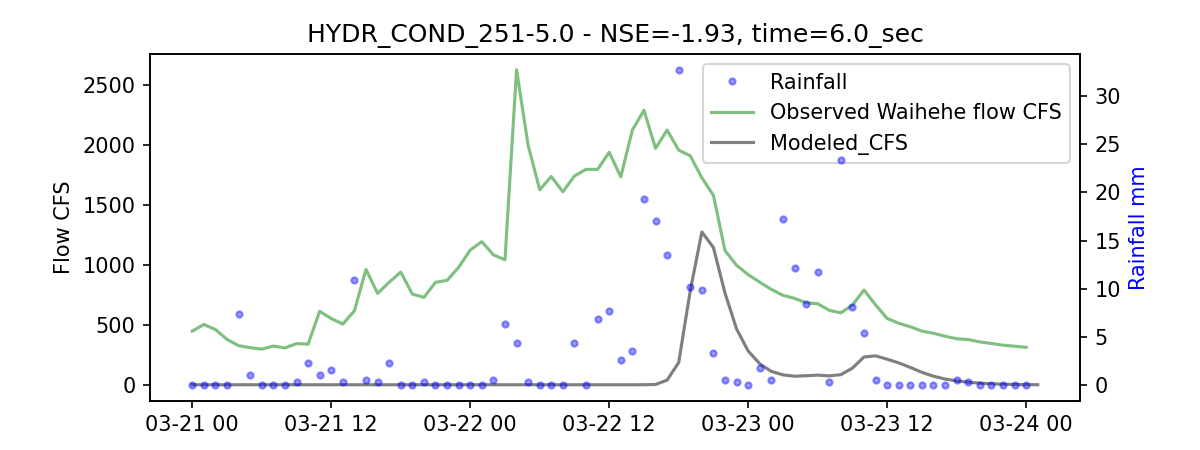

The NSE is -1.6482205277872741


<IPython.core.display.Javascript object>


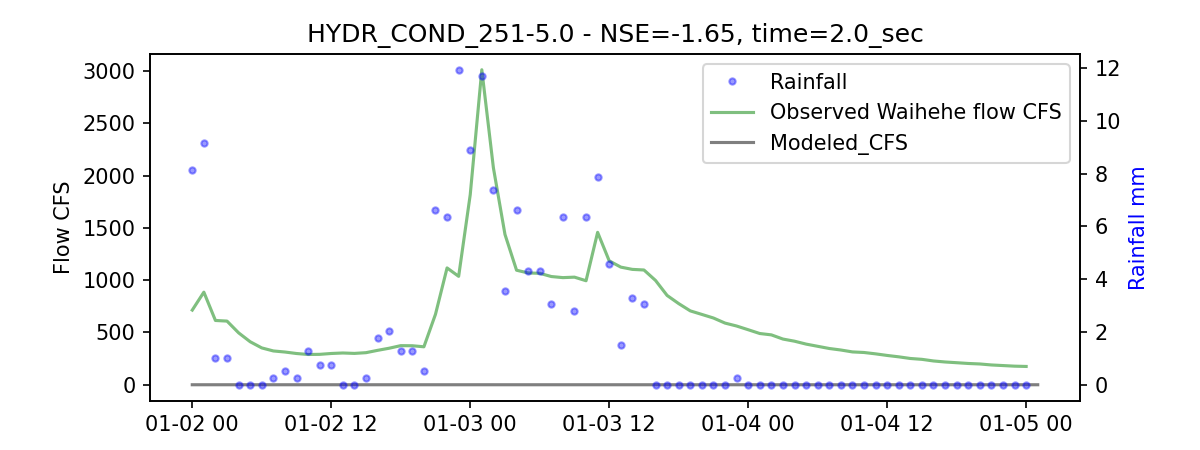

The NSE is -2.8566561201552174


<IPython.core.display.Javascript object>


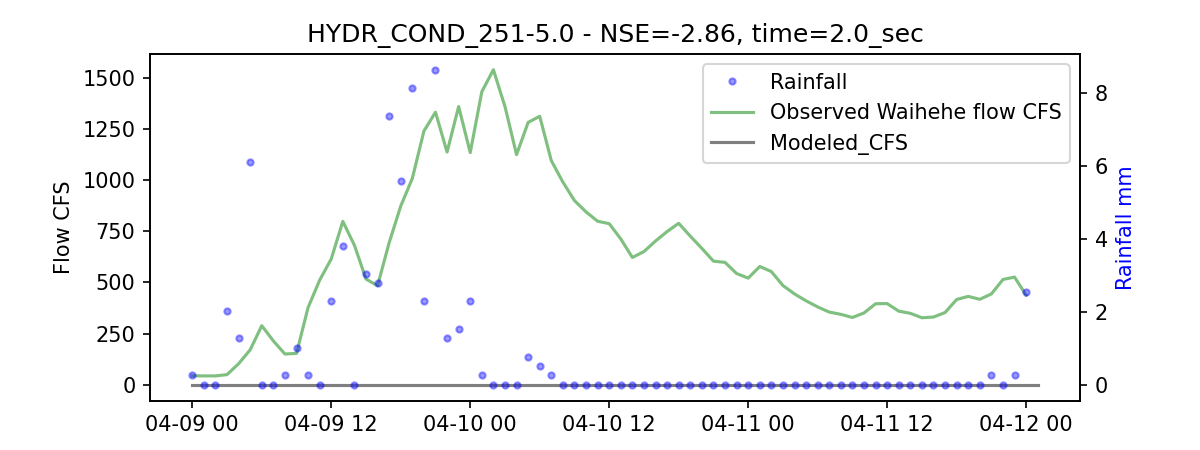

The NSE is -0.8639701023242077


<IPython.core.display.Javascript object>


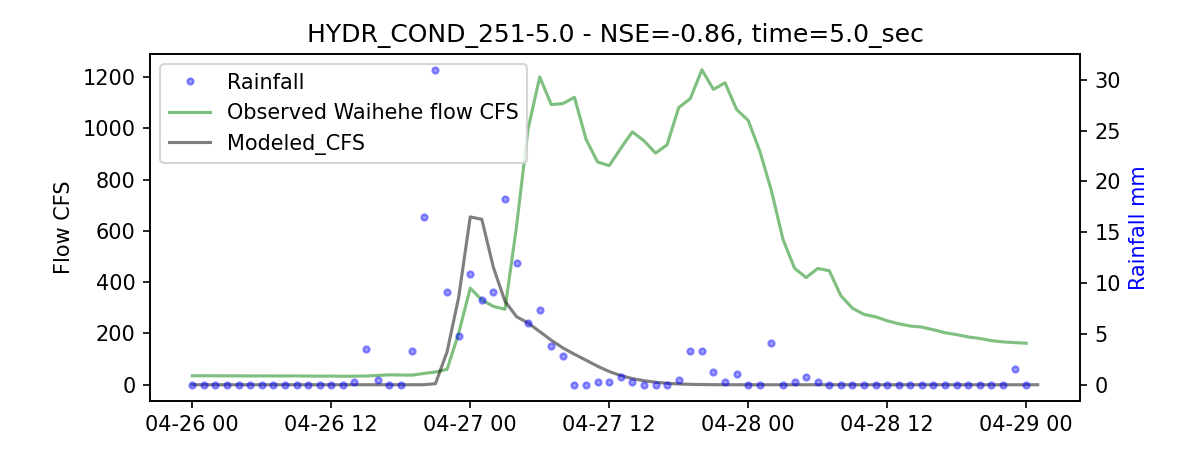

The NSE is -10.324472811463025


<IPython.core.display.Javascript object>


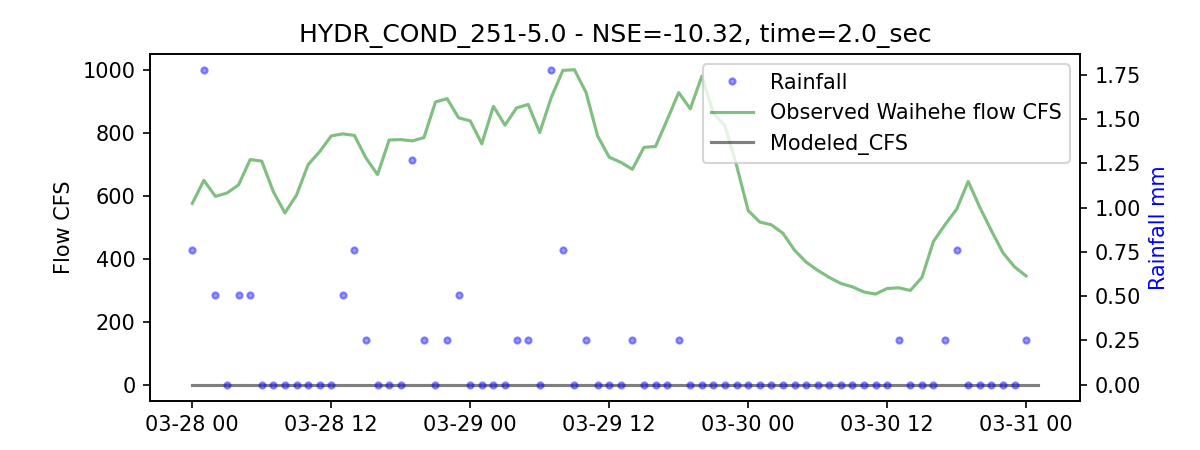

The NSE is -3.016376116105099


<IPython.core.display.Javascript object>


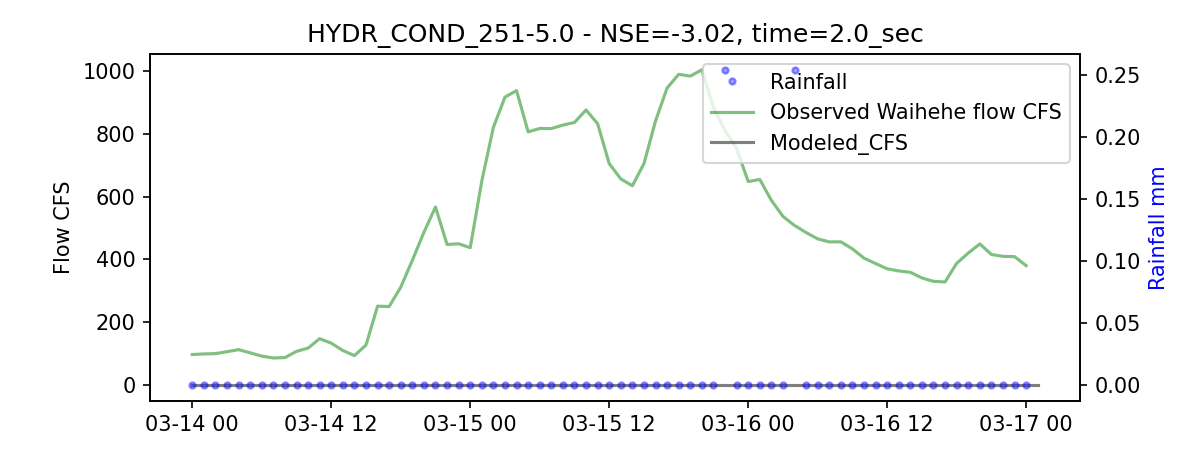

The NSE is -1.7393364833959435


<IPython.core.display.Javascript object>


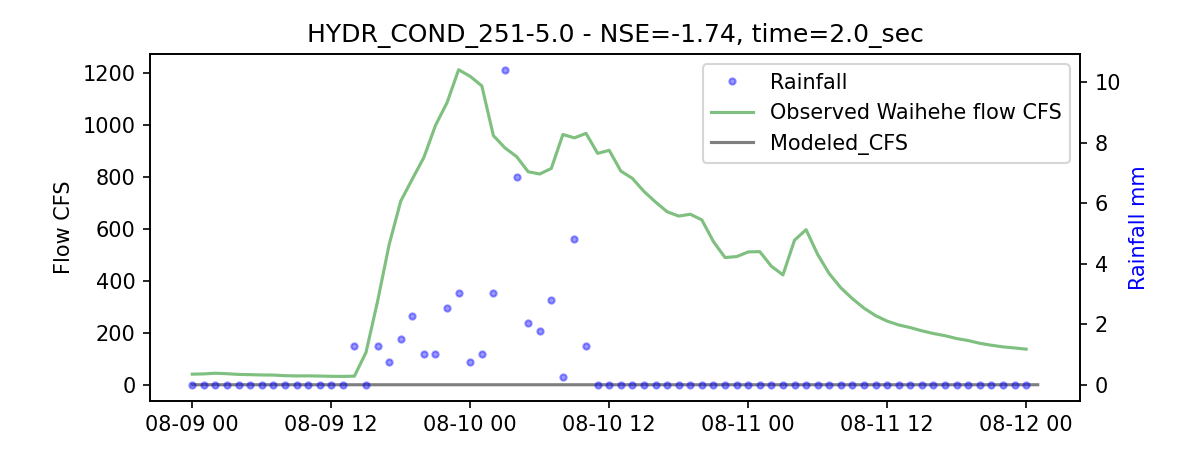

The NSE is -1.578531544784076


<IPython.core.display.Javascript object>


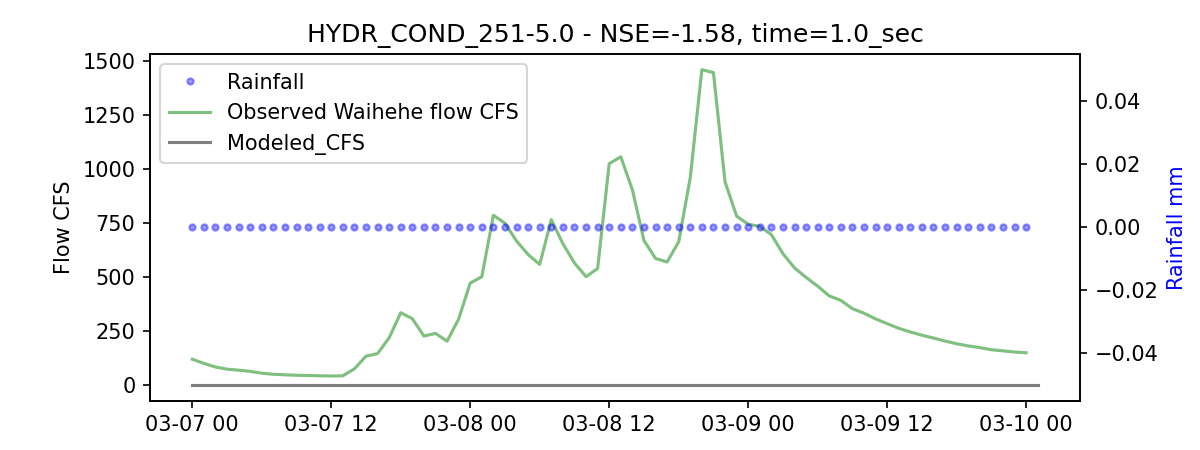

The NSE is -1.9950403969124992


<IPython.core.display.Javascript object>


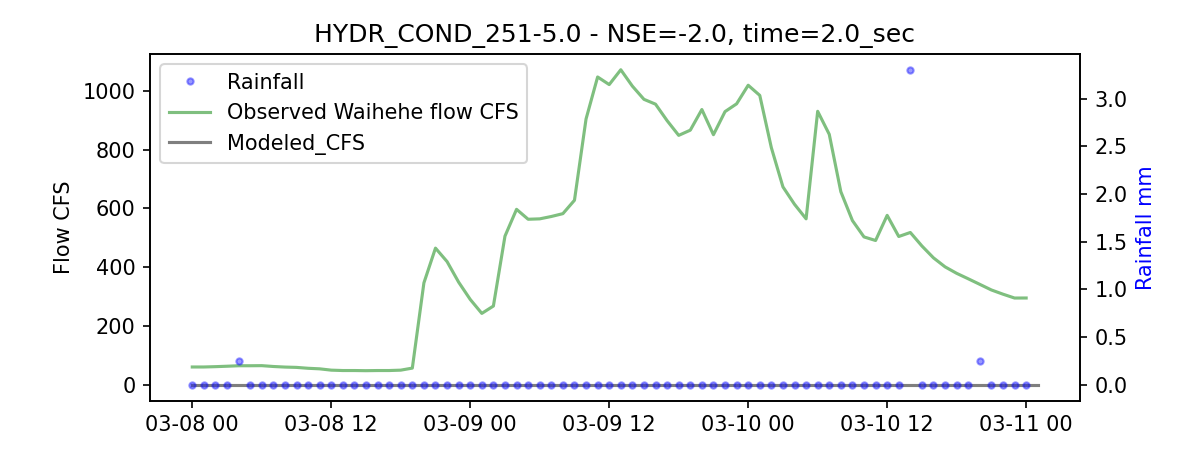

The NSE is -1.477139043159493


<IPython.core.display.Javascript object>


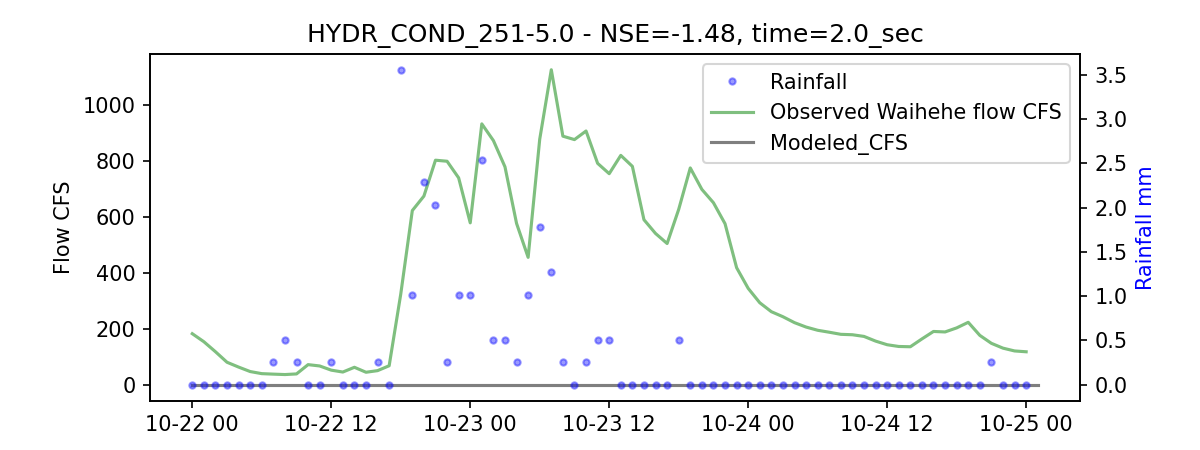

The NSE is -2.4606862821966926


<IPython.core.display.Javascript object>


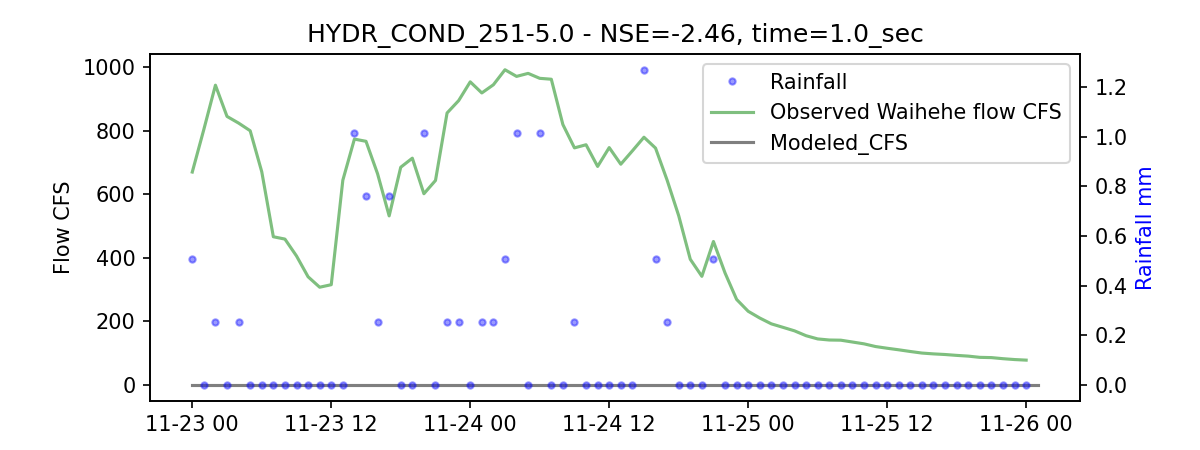

The NSE is -10.582559514441012


<IPython.core.display.Javascript object>


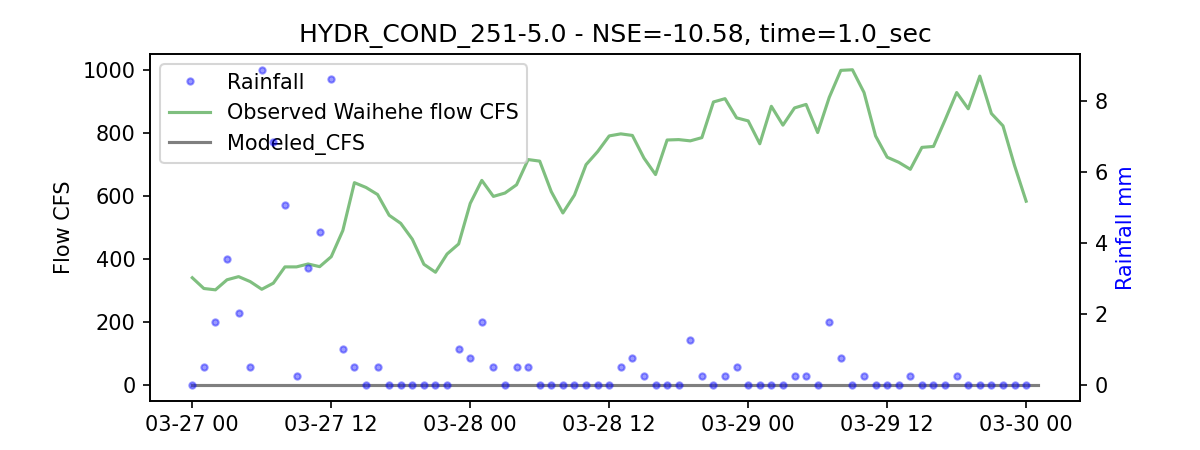

The NSE is -0.6213551119528611


<IPython.core.display.Javascript object>


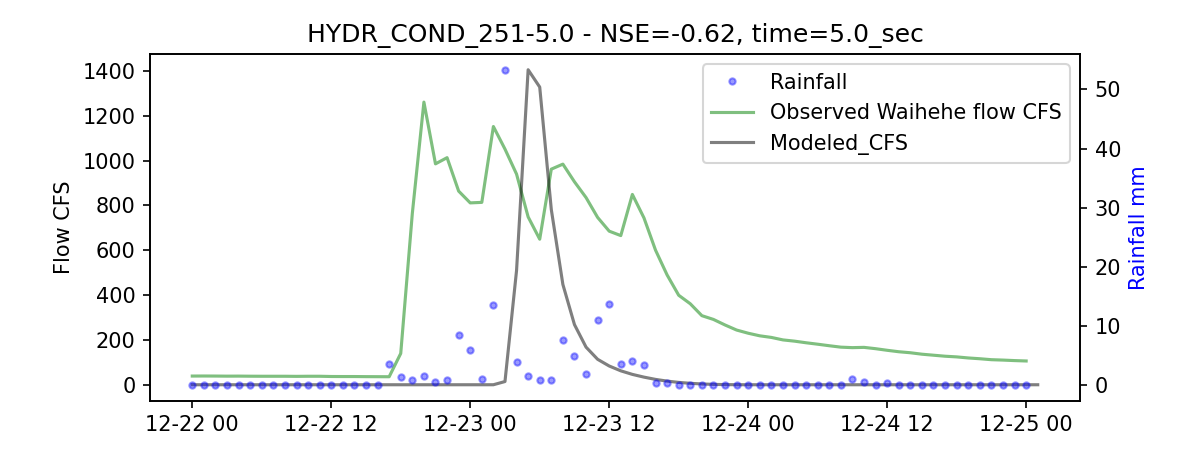

The NSE is -1.0183922717860585


<IPython.core.display.Javascript object>


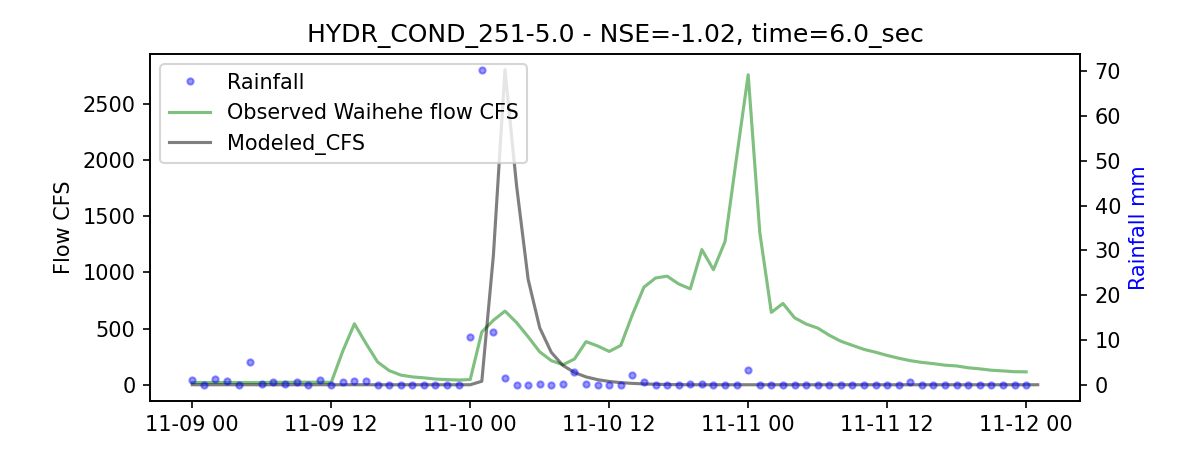

The NSE is -1.8277594490935822


<IPython.core.display.Javascript object>


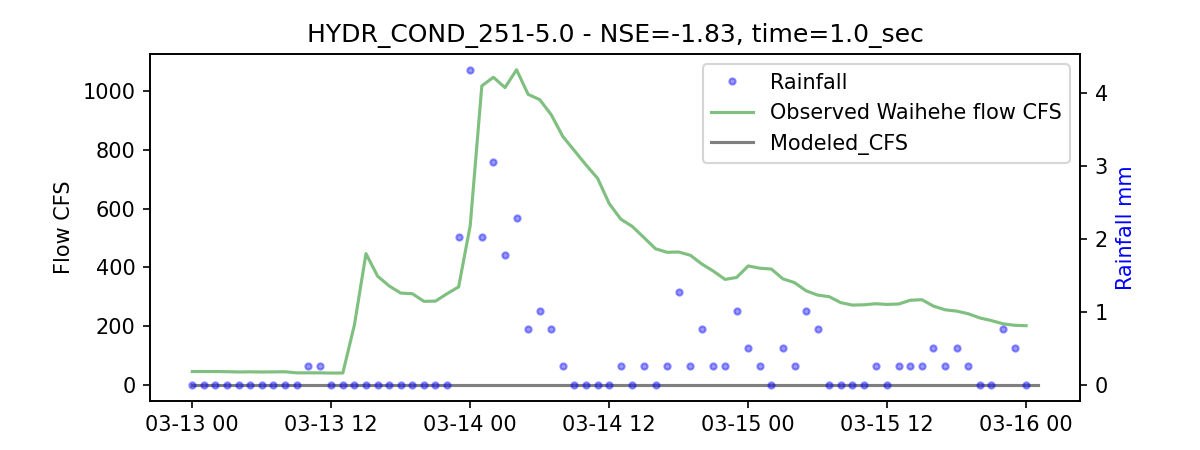

The NSE is -3.0669115750854283


<IPython.core.display.Javascript object>


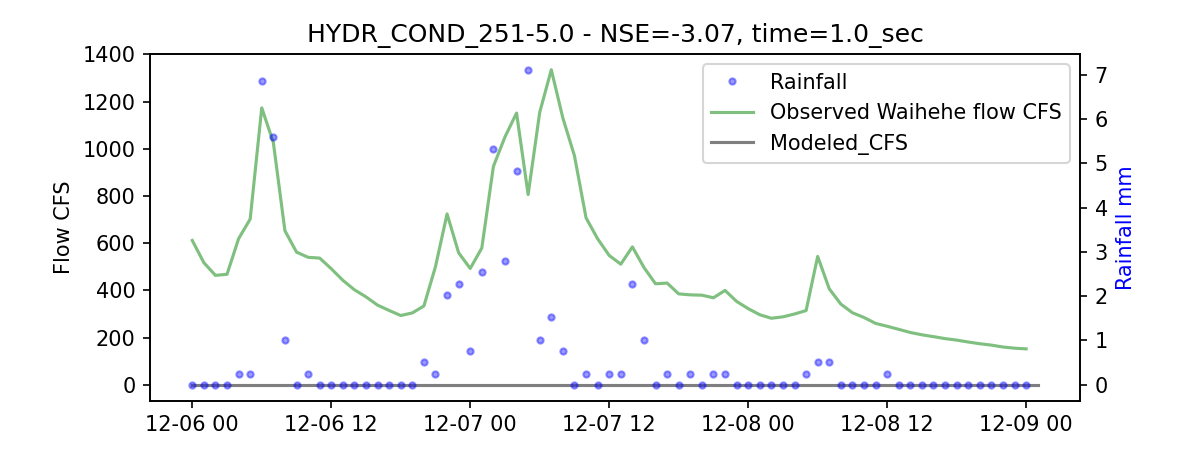

The NSE is -2.510743570531863


<IPython.core.display.Javascript object>


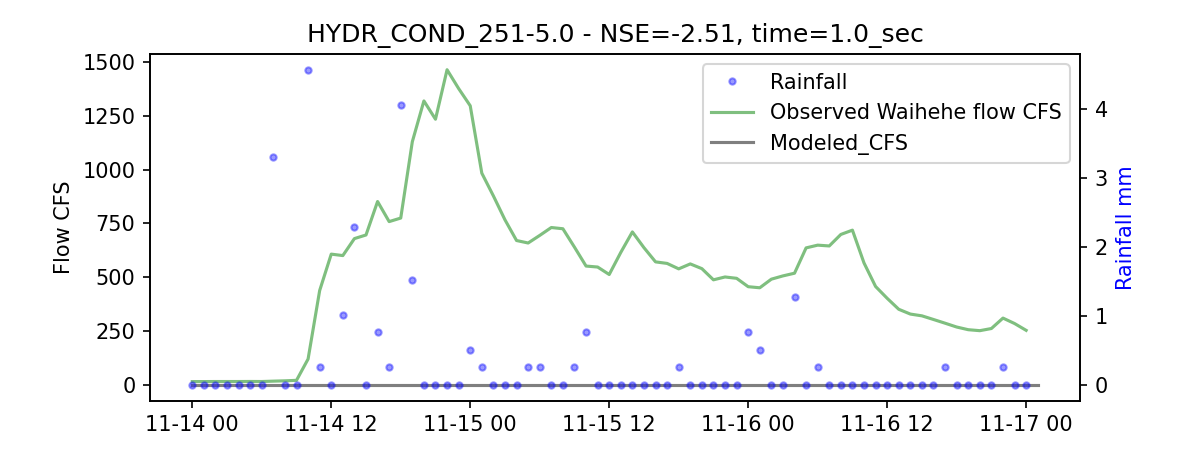

The NSE is -2.554740235287213


<IPython.core.display.Javascript object>


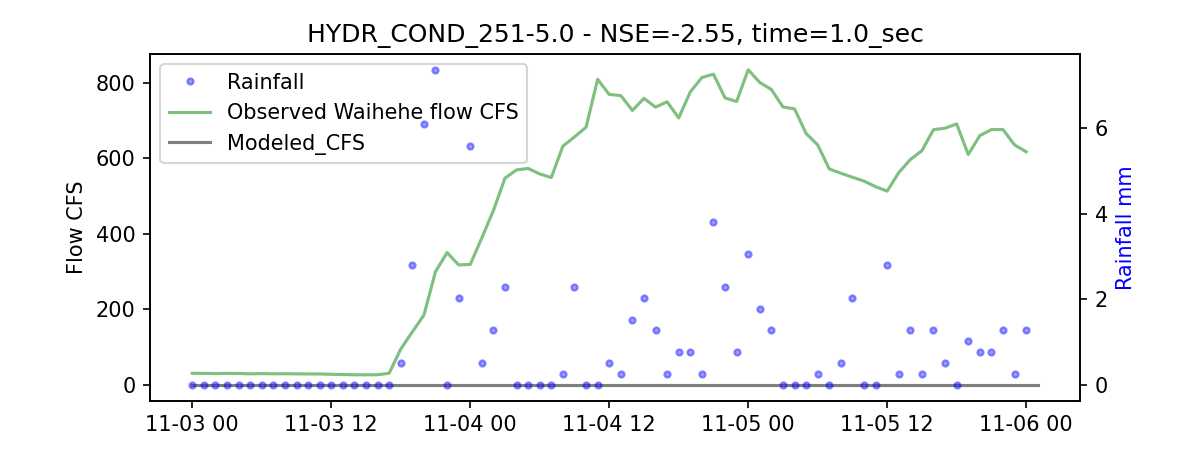

The NSE is -6.42311390913068


<IPython.core.display.Javascript object>


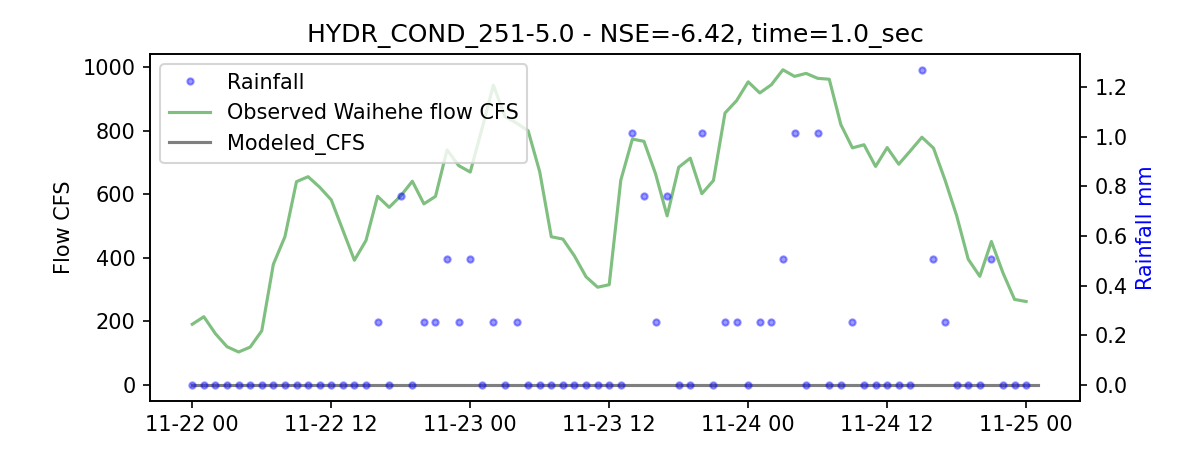

The NSE is -16.170272371094605


<IPython.core.display.Javascript object>


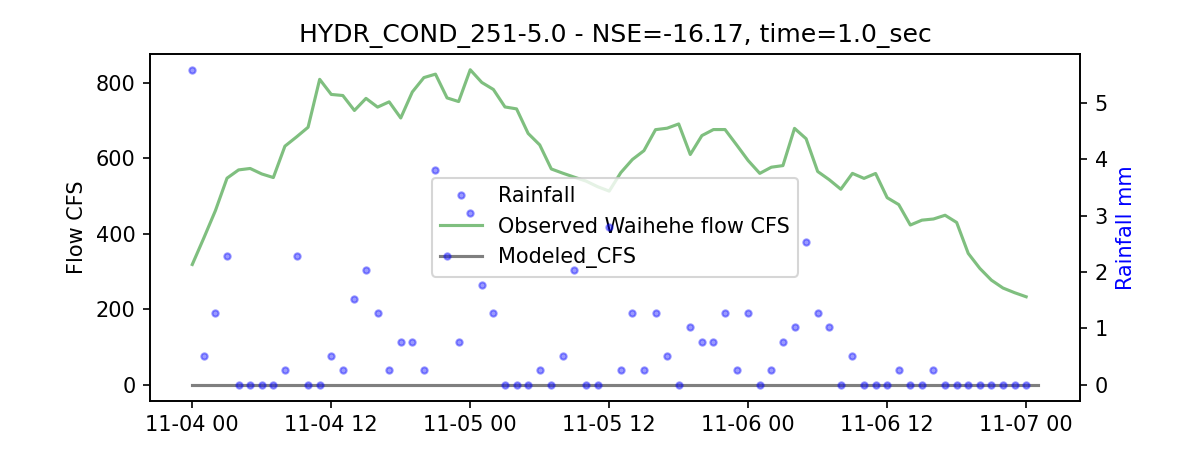

The NSE is -3.3256310345333837


C:\Users\CS\Desktop\Local_Project_Folders\AdSci_Watershed\Scripts\From_Scratch_4_May2023\pyGSSHA_functions.py:316: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 3))


<IPython.core.display.Javascript object>


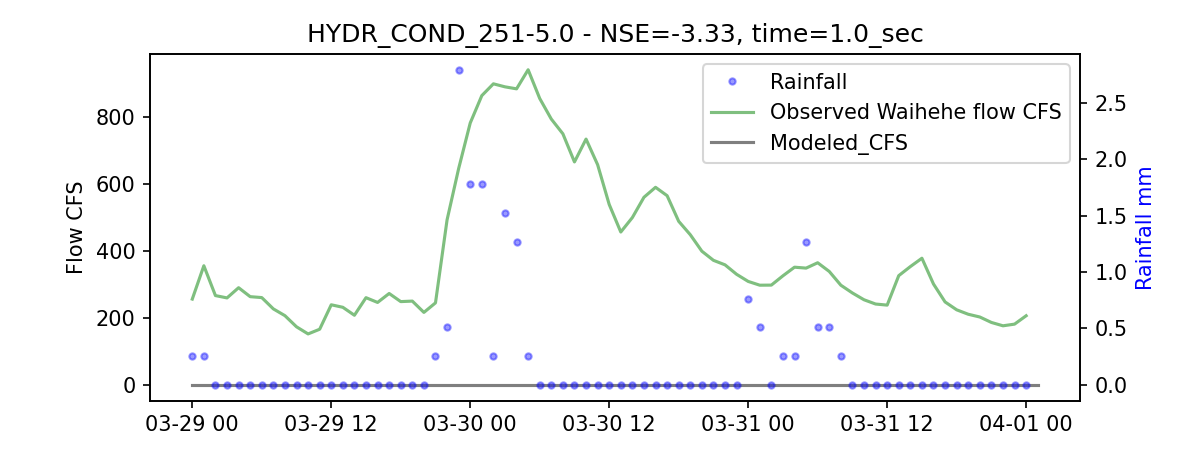

The NSE is -1.001353844068925


<IPython.core.display.Javascript object>


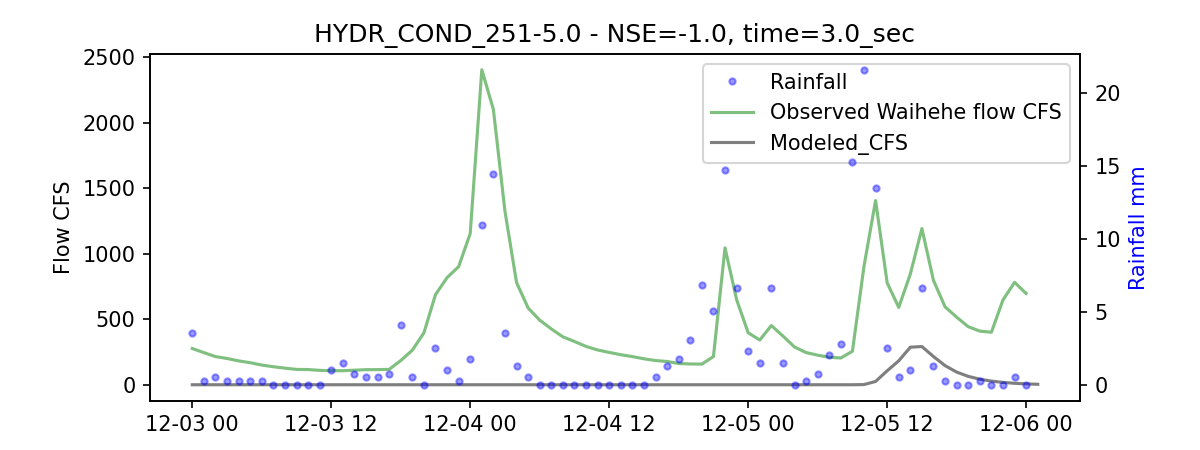

The NSE is -0.9354137465615875


<IPython.core.display.Javascript object>


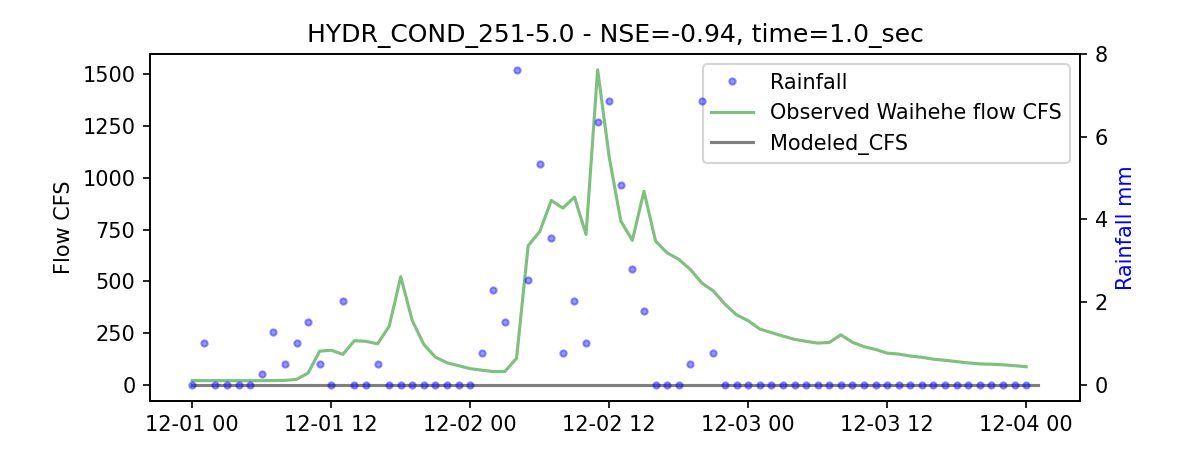

The NSE is -2.247447554771807


<IPython.core.display.Javascript object>

The NSE is -3.135510415556836


<IPython.core.display.Javascript object>

The NSE is -0.9258408592188545


<IPython.core.display.Javascript object>

The NSE is -6.753574117715513


<IPython.core.display.Javascript object>

The NSE is -7.433041194289913


<IPython.core.display.Javascript object>


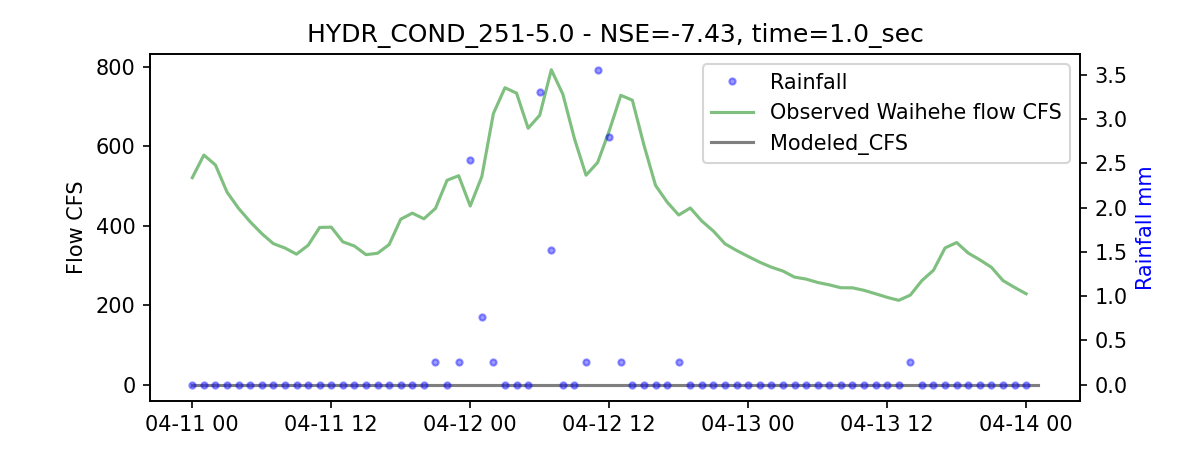

The NSE is -0.9742120039731328


<IPython.core.display.Javascript object>


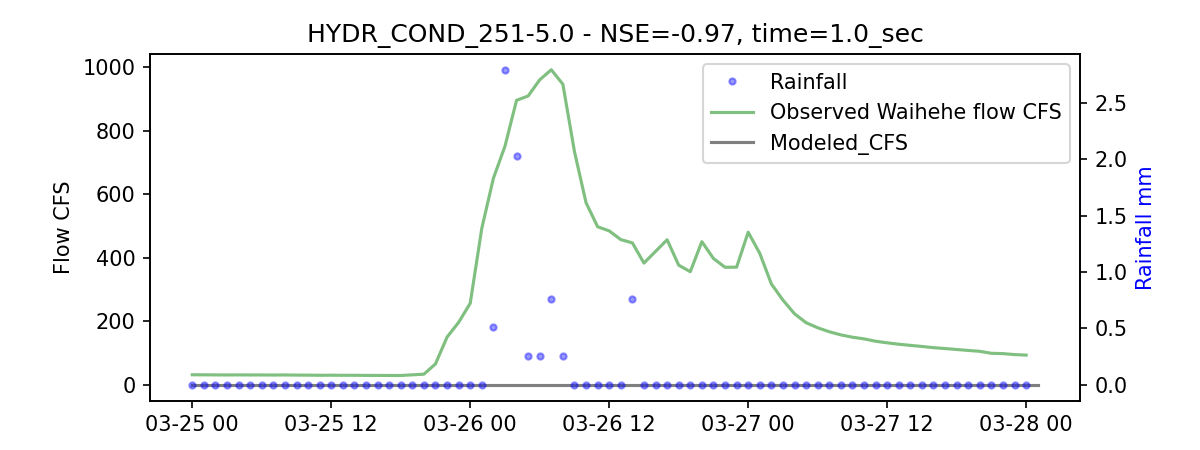

The NSE is -1.103828966106939


<IPython.core.display.Javascript object>


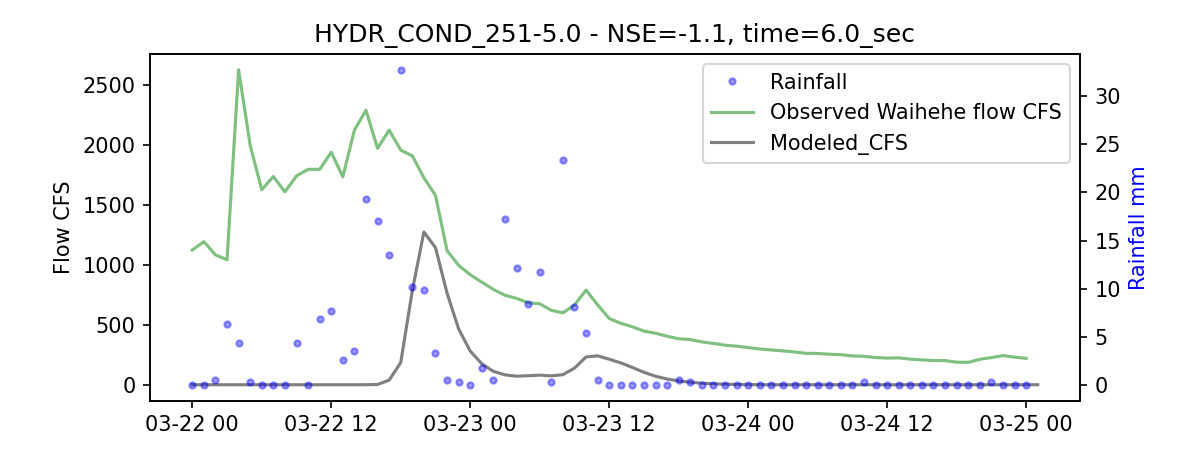

The NSE is -2.4956569657292467


<IPython.core.display.Javascript object>


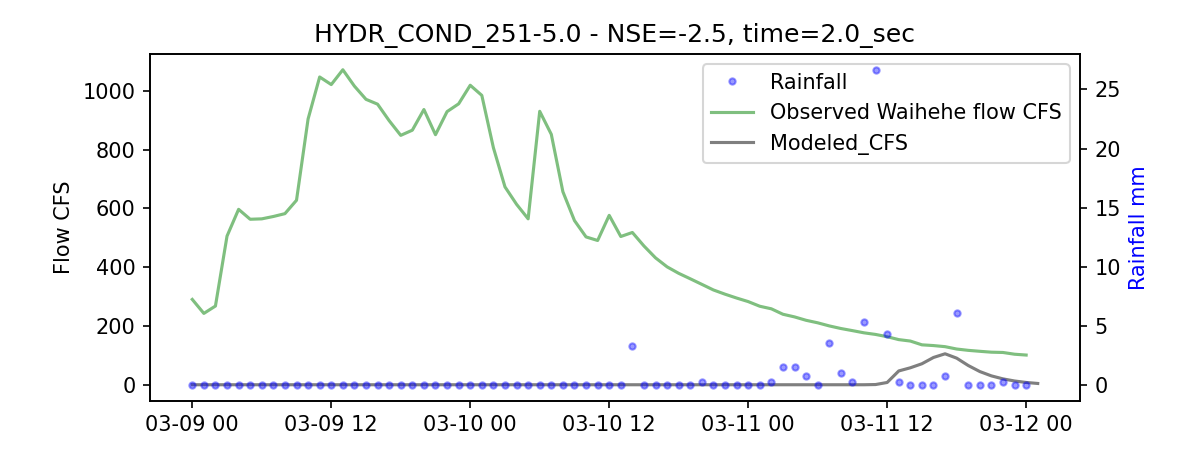

The NSE is -1.7368504606768242


<IPython.core.display.Javascript object>


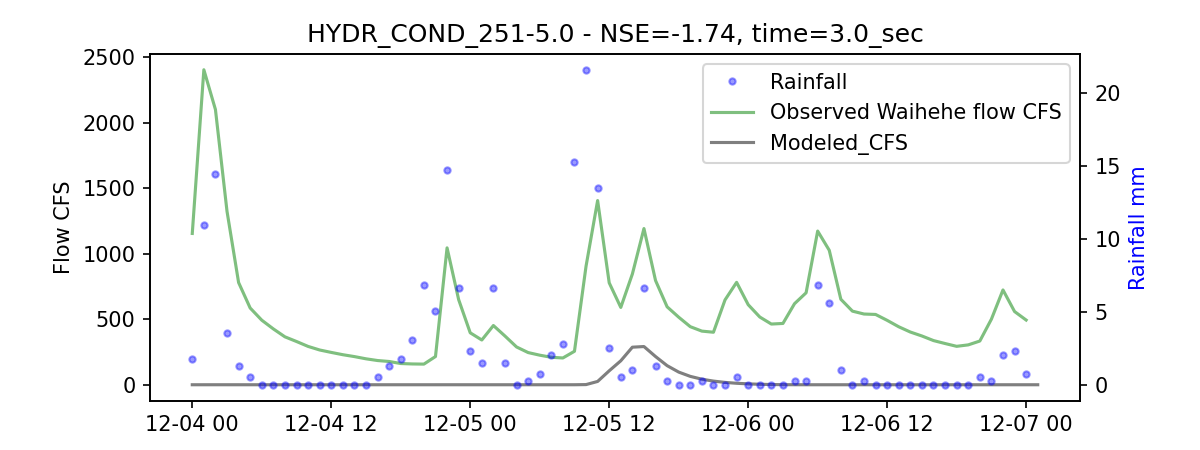

The NSE is 0.11571244181423435


<IPython.core.display.Javascript object>


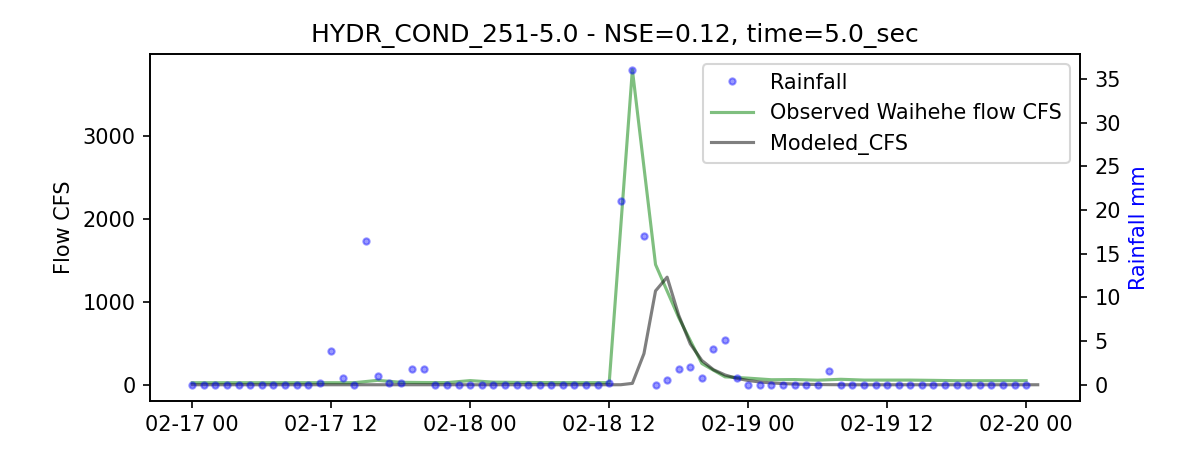

The NSE is 0.17225467051991306


<IPython.core.display.Javascript object>


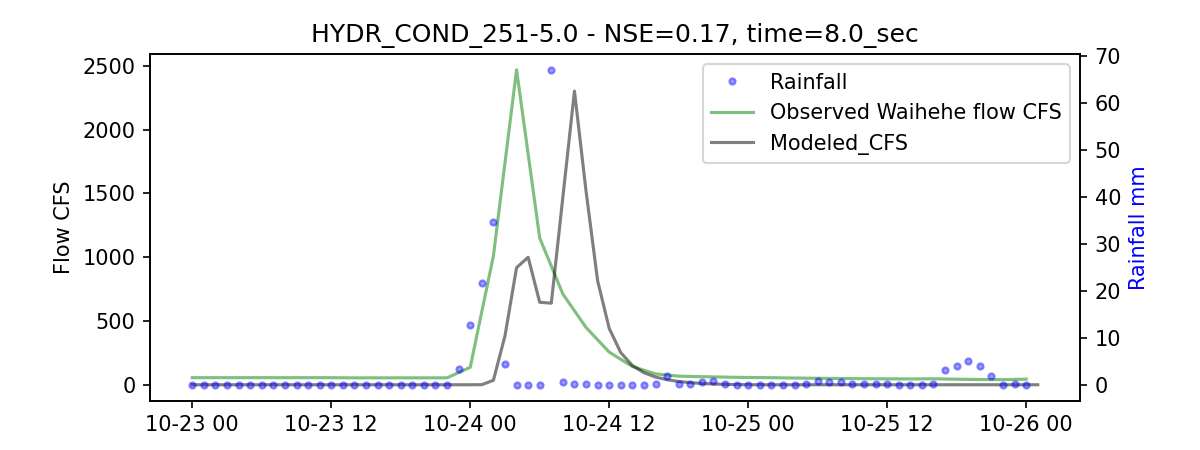

The NSE is -3.9186261042748676


<IPython.core.display.Javascript object>


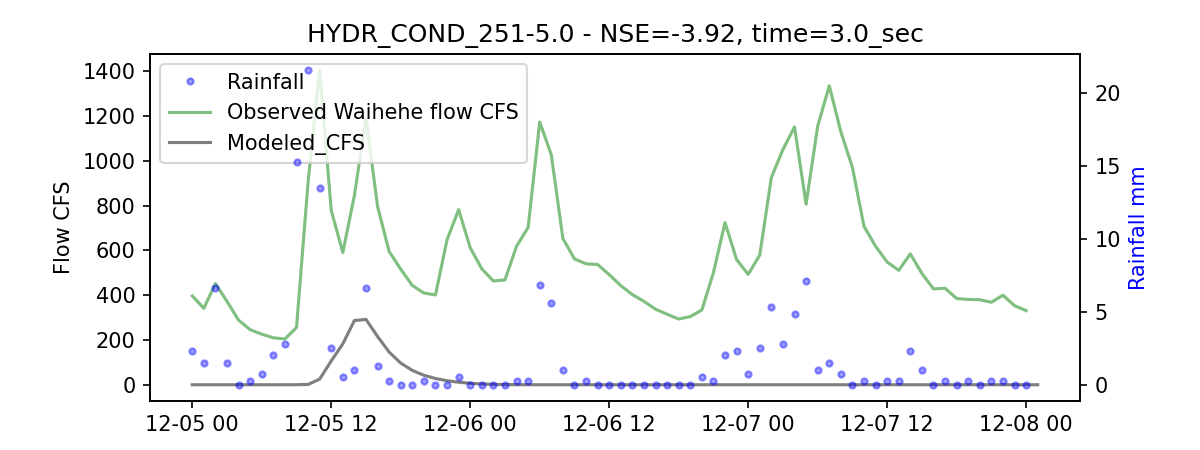

The NSE is -1.1617099147743342


<IPython.core.display.Javascript object>


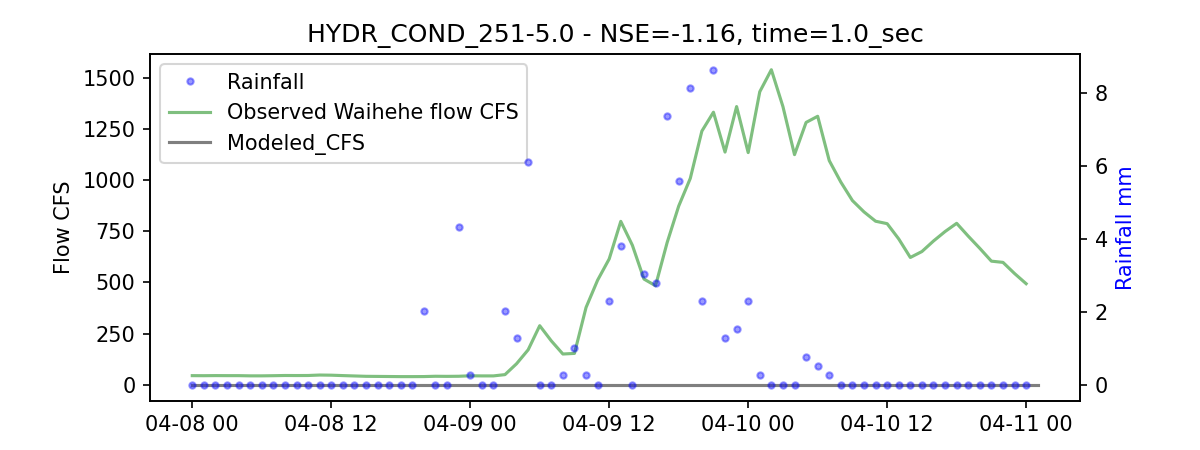

The NSE is -1.701623262385822


<IPython.core.display.Javascript object>


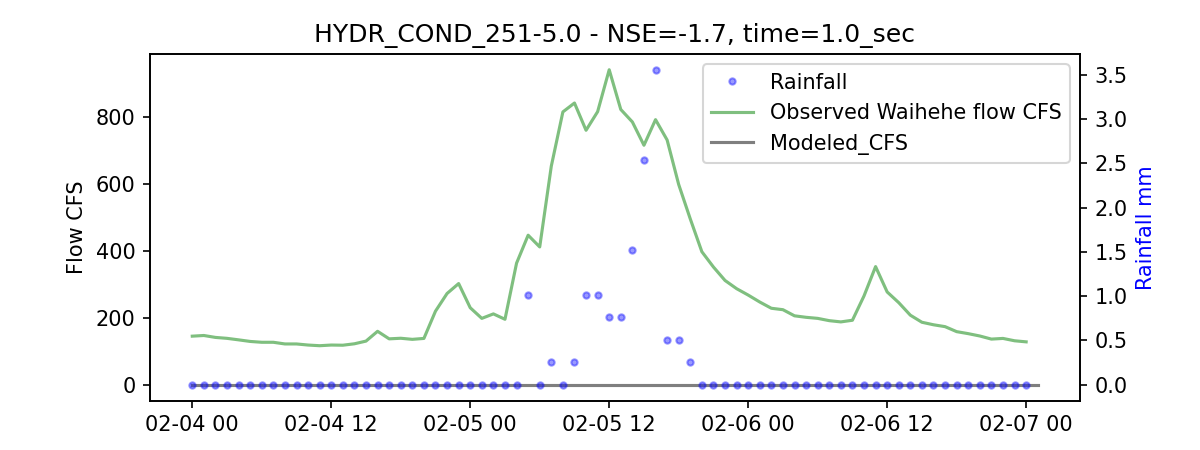

The NSE is -5.430297961526637


<IPython.core.display.Javascript object>


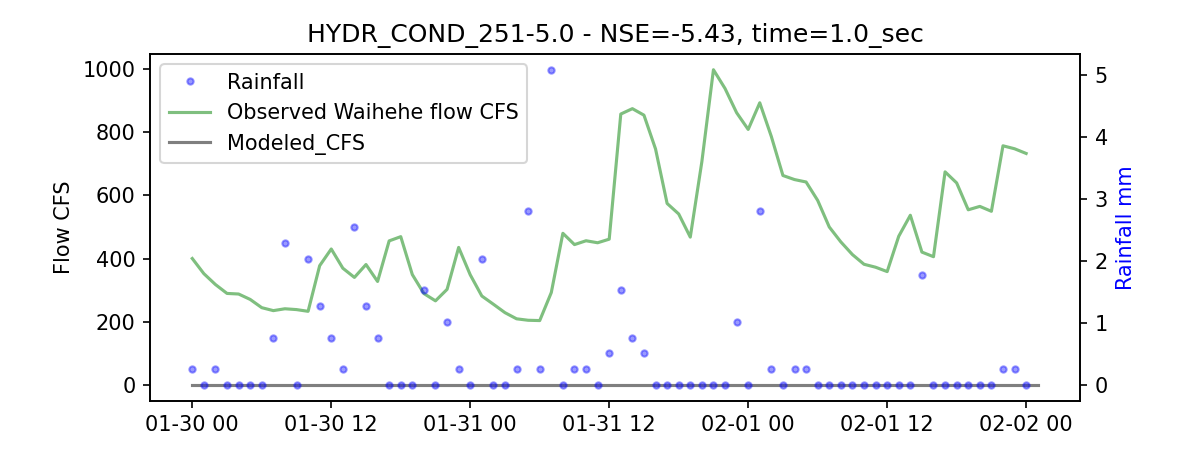

In [170]:
#Iterate over multiple rainfall events, keep other parameters stable 

for idx, val in enumerate(starts): 
    
    # Set new start and end dates for each run 
    StartDate = starts[idx]                      # depending on the format of the input might need .strftime('%Y-%m-%d %H:%M')
    EndDate = ends[idx]                        # was using just (bigdate+timedelta(days=2)).strftime('%Y-%m-%d %H:%M')

    refresh_model(PrjName)    # Nuke out the RUN directory to start fresh

    assign_cmt_base_vals(Code_Key_df, Code_list_in_WMS, PrjName)  # Use the dataframe and list of parameters above to assign the base values to all 


    # Rewrite Gag file and make run length the same as the file 
    Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                       Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                       Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

    # use unique start date to create streamflow obs file 
    SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)


    ##### RUN GSSHA    ######
    elapsed = run_GSSHA(PrjName, RUN_dir)

    # Postprocessing and plotting 
    OutHydro = process_otl_file(StartDate, PrjName)   # Process output hydrograph
    RunID = "{}-{}".format(str(Param_1_name), str(param_val))
    Plot_and_Compare(OutHydro, SlicedStreamflow_df, Rain_Data_Frame,  RunID, elapsed)  

Empty DataFrame
Columns: [trash, datedumb, Rainfall]
Index: []

In [138]:
SliceFrame = Input_Precip_df['2004-04-09 00:00': '2004-04-12 00:00']

if SliceFrame['RF_mm'].isnull().values.any() | SliceFrame.empty:
    print("POO")
    
SliceFrame

RF_mm
datetime                  
2004-04-09 00:00:00  0.254
2004-04-09 01:00:00  0.000
2004-04-09 02:00:00  0.000
2004-04-09 03:00:00  2.032
2004-04-09 04:00:00  1.270
2004-04-09 05:00:00  6.096
2004-04-09 06:00:00  0.000
2004-04-09 07:00:00  0.000
2004-04-09 08:00:00  0.254
2004-04-09 09:00:00  1.016
2004-04-09 10:00:00  0.254
2004-04-09 11:00:00  0.000
2004-04-09 12:00:00  2.286
2004-04-09 13:00:00  3.810
2004-04-09 14:00:00  0.000
2004-04-09 15:00:00  3.048
2004-04-09 16:00:00  2.794
2004-04-09 17:00:00  7.366
2004-04-09 18:00:00  5.588
2004-04-09 19:00:00  8.128
2004-04-09 20:00:00  2.286
2004-04-09 21:00:00  8.636
2004-04-09 22:00:00  1.270
2004-04-09 23:00:00  1.524
2004-04-10 00:00:00  2.286
2004-04-10 01:00:00  0.254
2004-04-10 02:00:00  0.000
2004-04-10 03:00:00  0.000
2004-04-10 04:00:00  0.000
2004-04-10 05:00:00  0.762
2004-04-10 06:00:00  0.508
2004-04-10 07:00:00  0.254
2004-04-10 08:00:00  0.000
2004-04-10 09:00:00  0.000
2004-04-10 10:00:00  0.000
2004-04-10 11:00:00  0.000
2004-04-10 12:00:00  0.000
2004-04-10 13:00:00  0.000
2004-04-10 14:00:00  0.000
2004-04-10 15:00:00  0.000
2004-04-10 16:00:00  0.000
2004-04-10 17:00:00  0.000
2004-04-10 18:00:00  0.000
2004-04-10 19:00:00  0.000
2004-04-10 20:00:00  0.000
2004-04-10 21:00:00  0.000
2004-04-10 22:00:00  0.000
2004-04-10 23:00:00  0.000
2004-04-11 00:00:00  0.000
2004-04-11 01:00:00  0.000
2004-04-11 02:00:00  0.000
2004-04-11 03:00:00  0.000
2004-04-11 04:00:00  0.000
2004-04-11 05:00:00  0.000
2004-04-11 06:00:00  0.000
2004-04-11 07:00:00  0.000
2004-04-11 08:00:00  0.000
2004-04-11 09:00:00  0.000
2004-04-11 10:00:00  0.000
2004-04-11 11:00:00  0.000
2004-04-11 12:00:00  0.000
2004-04-11 13:00:00  0.000
2004-04-11 14:00:00  0.000
2004-04-11 15:00:00  0.000
2004-04-11 16:00:00  0.000
2004-04-11 17:00:00  0.000
2004-04-11 18:00:00  0.000
2004-04-11 19:00:00  0.000
2004-04-11 20:00:00  0.000
2004-04-11 21:00:00  0.254
2004-04-11 22:00:00  0.000
2004-04-11 23:00:00  0.254
2004-04-12 00:00:00  2.540

In [129]:
SliceFrame

Empty DataFrame
Columns: [RF_mm]
Index: []

In [132]:
SliceFrame.empty

True

In [ ]:
    except: 
        print("run with {} is no good".format(StartDate))